# 1D-ARC Neural Cellular Automata

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [1]:
import json
import os

import jax
import jax.numpy as jnp
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.depthwise_conv_perceive import DepthwiseConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.update.residual_update import ResidualUpdate
from flax import nnx
from tqdm.auto import tqdm

## Configuration

In [ ]:
seed = 0

channel_size = 32
num_spatial_dims = 1
num_kernels = 2
hidden_size = 256
cell_dropout_rate = 0.5

batch_size = 8
num_steps = 128
learning_rate = 1e-3

ds_size = 128

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Dataset

In [ ]:
# Install 1D-ARC dataset
!git clone https://github.com/khalil-research/1D-ARC.git

In [81]:
ds_path = "./1D-ARC/dataset"

train_examples = []
test_examples = []
task_index_to_name = {}


def process_example(example, task_index):
	input_data = jnp.squeeze(jnp.array(example["input"], dtype=jnp.int32))
	output_data = jnp.squeeze(jnp.array(example["output"], dtype=jnp.int32))

	assert input_data.shape == output_data.shape

	pad_size = ds_size - input_data.size
	pad_left, pad_right = pad_size // 2, pad_size - pad_size // 2

	input_padded = jnp.pad(input_data, (pad_left, pad_right))
	output_padded = jnp.pad(output_data, (pad_left, pad_right))

	return jnp.expand_dims(
		jnp.concatenate([jnp.array([task_index], dtype=jnp.int32), input_padded, output_padded]), axis=-1
	)


for task_index, task_name in enumerate(os.listdir(ds_path)):
	task_index_to_name[task_index] = task_name
	task_path = os.path.join(ds_path, task_name)

	for task_file in os.listdir(task_path):
		with open(os.path.join(task_path, task_file)) as f:
			data = json.load(f)
			for split, examples in [("train", train_examples), ("test", test_examples)]:
				examples.extend(process_example(ex, task_index) for ex in data[split])

train_tasks = jnp.array(train_examples)
test_tasks = jnp.array(test_examples)

task_list = list(task_index_to_name.values())

## Init state

In [19]:
def init_state(key):
	# Sample dataset
	sample = jax.random.choice(key, train_tasks)

	# Sample input and target
	task_index, input, target = jnp.split(sample, indices_or_sections=[1, ds_size + 1])

	# Initialize state
	state = jnp.zeros((ds_size, channel_size))
	state = state.at[..., :1].set(input)
	return state, target, task_index


def init_state_test(key):
	# Sample dataset
	sample = jax.random.choice(key, test_tasks)

	# Sample input and target
	task_index, input, target = jnp.split(sample, indices_or_sections=[1, ds_size + 1])

	# Initialize state
	state = jnp.zeros((ds_size, channel_size))
	state = state.at[..., :1].set(input)
	return state, target, task_index

## Model

In [6]:
perceive = DepthwiseConvPerceive(channel_size=channel_size, rngs=rngs, num_kernels=num_kernels, kernel_size=(3,))
update = ResidualUpdate(
	num_spatial_dims=num_spatial_dims,
	channel_size=channel_size,
	perception_size=num_kernels * channel_size + 8,
	hidden_layer_sizes=(hidden_size,),
	rngs=rngs,
	cell_dropout_rate=cell_dropout_rate,
)
embed_input = nnx.Embed(num_embeddings=10, features=3, rngs=rngs)
embed_task = nnx.Embed(num_embeddings=len(task_list), features=8, rngs=rngs)


class EmbedCA(CA):
	embed_input: nnx.Embed
	embed_task: nnx.Embed

	def __init__(self, perceive, update, embed_input, embed_task):
		super().__init__(perceive, update)

		self.embed_input = embed_input
		self.embed_task = embed_task

In [7]:
kernel = jnp.concatenate([identity_kernel(ndim=1), grad_kernel(ndim=1)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.depthwise_conv.kernel = nnx.Param(kernel)

In [8]:
ca = EmbedCA(perceive, update, embed_input, embed_task)

In [ ]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree.reduce(lambda x, y: x + y.size, params, 0))

## Train

In [10]:
lr_sched = optax.linear_schedule(init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [11]:
def mse(state, target):
	return jnp.mean(jnp.square(state[..., :3] - target))

In [12]:
@nnx.jit
def loss_fn(ca, state, target, task_index):
	# Embed
	input = state[..., 0]
	input_embed = ca.embed_input(jnp.asarray(input, dtype=jnp.int32))
	task_embed = ca.embed_task(jnp.asarray(task_index, dtype=jnp.int32))
	state = state.at[..., :3].set(input_embed)

	target_embed = ca.embed_input(jnp.asarray(target[..., 0], dtype=jnp.int32))

	state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
	state = nnx.split_rngs(splits=batch_size)(
		nnx.vmap(
			lambda ca, state, task_embed: ca(state, task_embed, num_steps=num_steps),
			in_axes=(state_axes, 0, 0),
		)
	)(ca, state, task_embed)

	loss = mse(state, target_embed)
	return loss

### Train step

In [13]:
@nnx.jit
def train_step(ca, optimizer, key):
	keys = jax.random.split(key, batch_size)
	state, target, task_index = jax.vmap(init_state)(keys)

	loss, grad = nnx.value_and_grad(loss_fn, argnums=nnx.DiffState(0, update_params))(ca, state, target, task_index)
	optimizer.update(grad)
	return loss

### Main loop

In [ ]:
num_train_steps = 8_192
print_interval = 128

pbar = tqdm(range(num_train_steps), desc="Training", unit="train_step")
losses = []

for i in pbar:
	key, subkey = jax.random.split(key)
	loss = train_step(ca, optimizer, subkey)
	losses.append(loss)

	if i % print_interval == 0 or i == num_train_steps - 1:
		avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
		pbar.set_postfix({"Average Loss": f"{avg_loss:.6f}"})

## Visualize

In [74]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 8)
state_init, target, task_index = jax.vmap(init_state_test)(keys)

input = state_init[..., 0]
input_embed = ca.embed_input(jnp.asarray(input, dtype=jnp.int32))
task_embed = ca.embed_task(jnp.asarray(task_index, dtype=jnp.int32))
state_init = state_init.at[..., :3].set(input_embed)

state_axes = nnx.StateAxes({nnx.RngState: 0, ...: None})
state = nnx.split_rngs(splits=batch_size)(
	nnx.vmap(
		lambda ca, state, task_embed: ca(state, task_embed, num_steps=num_steps, all_steps=True),
		in_axes=(state_axes, 0, 0),
	)
)(ca, state_init, task_embed)

state_rgb = jnp.concatenate([jnp.expand_dims(state_init[..., :3], axis=1), state[..., :3]], axis=1)

1d_hollow,1d_recolor_oe,1d_pcopy_1c,1d_recolor_cmp,1d_flip,1d_move_2p,1d_move_3p,1d_denoising_mc

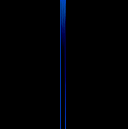
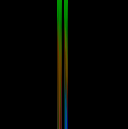
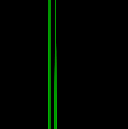
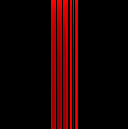
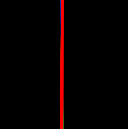
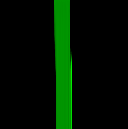
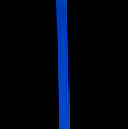
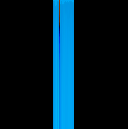

In [41]:
task_name = [task_list[int(jnp.squeeze(task_index))] for task_index in task_index]
mediapy.show_images(state_rgb, titles=task_name, width=256, height=256)